In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from unwrap import unwrap

basePath = '/media/robert/Data_Storage/Data/Diagnostic/Phase_Diagnostic/Nominal_Plasma/'

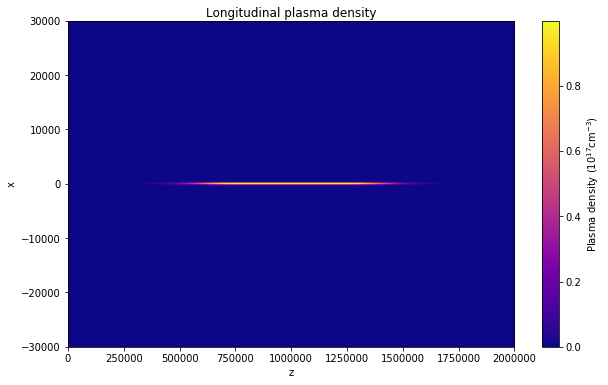

In [2]:
path = basePath + 'Oblique/1e17_w-10e3_theta-0.859/'
# Build the plasma
plasmaParams = {
    'Nx' : 2**12,
    'Ny' : 2**10,
    'Nz' : 2**8,
    'X' : 60e3,
    'Y' : 60e3,
    'Z' : 2.0e6, 
    'n0' : 1.0,
    'atom' : ionization.Ar,
    'path' : path,
    'name' : 'ArgonPlasma',
    'load' : False,
    'cyl' : True
}

w = 200
z0 = 0.75e6
zf = plasmaParams['Z']
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
z, ne = profile.plasma_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, plasmaParams['Nz'], zf)

argon = plasma.Plasma(plasmaParams)
n = np.full((argon.Nx, argon.Ny, argon.Nz), plasmaParams['n0'], dtype='double')
r2 = argon.x[:, None, None]**2 + argon.y[None, :, None]**2
ne = plasmaParams['n0'] * ne[None, None, :] * np.exp(-r2/w**2)
argon.initialize_plasma(n, ne)
del n
del ne
argon.plot_long_density_center()

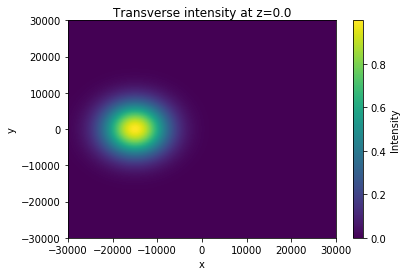

In [3]:
# Build the beam
beamParams = {
    'Nx' : plasmaParams['Nx'],
    'Ny' : plasmaParams['Ny'],
    'X' : plasmaParams['X'],
    'Y' : plasmaParams['Y'],
    'lam' : 0.8,
    'path' : path,
    'name' : 'ProbePulse',
    'load' : False,
    'threads' : 4,
    'cyl' : False,
    'E0' : 27.44923, # Gives peak input intensity of 1.0
    'waist' : 10000,
    'z0' : 0.0,
    'theta' : 0.859,
    'dx' : -15e3
}

beam = laserbeam.GeneralGaussianLaser(beamParams)
beam.plot_current_intensity()

In [4]:
interactions.beam_plasma(beam, argon)

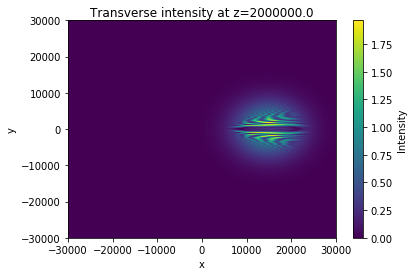

In [5]:
beam.plot_intensity_at(255)

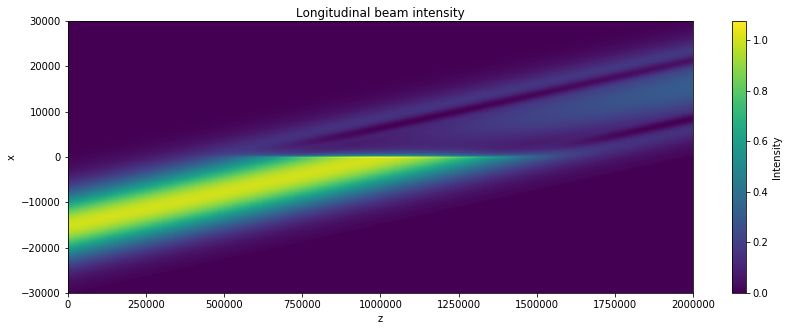

In [6]:
e = np.zeros((argon.Nz, beam.Nx), dtype='complex128')
Z = argon.Z
X = plasmaParams['X']
for i in range(argon.Nz):
    e[i, :] = beam.load_field(i)[0][:, int(beam.Ny/2)]
I = beam.intensity_from_field(e)
plt.figure(figsize=(14, 5))
plt.imshow(beam.prep_data(I), aspect='auto', extent=[0, Z, -X/2, X/2])
cb = plt.colorbar()
cb.set_label(r'Intensity')
plt.set_cmap('viridis')
plt.title('Longitudinal beam intensity')
plt.xlabel(r'z')
plt.ylabel(r'x')
plt.show()

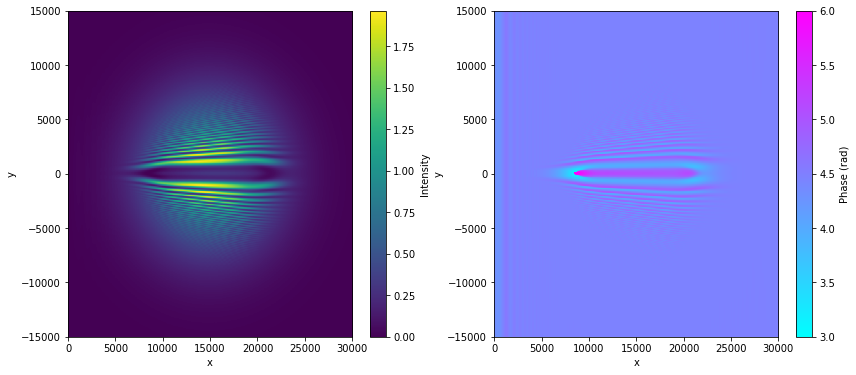

In [7]:
e, z = beam.load_field(plasmaParams['Nz']-1)
I = beam.intensity_from_field(e)
phi = unwrap(np.angle(e)) - beam.k*np.radians(beam.theta)*beam.x[:, None]
phi -= np.amin(phi)
X = plasmaParams['X']
Y = plasmaParams['Y']
xlim = [0, 30e3]
ylim = [-15e3, 15e3]

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.imshow(beam.prep_data(I), aspect='auto', extent=[-X/2, X/2, -Y/2, Y/2])
cb = plt.colorbar()
cb.set_label(r'Intensity')
plt.set_cmap('viridis')
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(122)
plt.imshow(beam.prep_data(phi), aspect='auto', extent=[-X/2, X/2, -Y/2, Y/2])
cb = plt.colorbar()
cb.set_label(r'Phase (rad)')
plt.set_cmap('cool')
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.xlim(xlim)
plt.ylim(ylim)
plt.clim(3,6)
plt.show()